In [1]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
import os
import torch.nn.functional as F

from src.utils.config import RESNET34_FULL,BEETLE_DATASET, Config, DEFAULT_TEST_PATH
from src.models import download_model, load_model_weights_and_metrics

import torchvision.models as models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

import pandas as pd

In [2]:
path = './output/tests/'
dataset_pred = np.load(path + 'dataset_predictions.npy')
dataset_class = np.load(path + 'dataset_classes.npy')
dataset_class_acc = np.load(path + 'dataset_class_acc.npy')
test_names = np.load(path + 'test_name.npy')
test_acc = np.load(path + 'test_acc.npy')

gen_files = []
enc_files = []
latents_files = []
pred_files = []
stat_files = []
class_acc_files = []

setup_types_folders = os.listdir(path)
setup_types_folders.sort()

for i in range(len(setup_types_folders)):
    current_folder = path + setup_types_folders[i] + '/'
    if os.path.isdir(current_folder):
        gen_f_temp = []
        enc_f_temp = []
        latents_f_temp = []
        pred_f_temp = []
        stat_f_temp = []
        class_acc_f_temp = []


        folder_temp = os.listdir(current_folder)
        folder_temp.sort()
        for j in range(len(folder_temp)):
            if folder_temp[j][-6:] == 'gen.pt':
                gen_f_temp.append(current_folder + folder_temp[j])
            if folder_temp[j][-6:] == 'enc.pt':
                enc_f_temp.append(current_folder + folder_temp[j])
            if folder_temp[j][-11:] == 'latents.npy':
                latents_f_temp.append(current_folder + folder_temp[j])
            if folder_temp[j][-8:] == 'pred.npy':
                pred_f_temp.append(current_folder + folder_temp[j])
            if folder_temp[j][-9:] == 'stats.npy':
                stat_f_temp.append(current_folder + folder_temp[j])
            if folder_temp[j][-13:] == 'class_acc.npy':
                class_acc_f_temp.append(current_folder + folder_temp[j])
        gen_files.append(gen_f_temp)
        enc_files.append(enc_f_temp)
        latents_files.append(latents_f_temp)
        pred_files.append(pred_f_temp)
        stat_files.append(stat_f_temp)
        class_acc_files.append(class_acc_f_temp)

In [3]:
test_names = np.array(['lambdas_adv', 'lambdas_equal', 'lambdas_feat', 'lambdas_img',
       'test_soft_35', 'test_soft_75', 'train_enc_layer3_200',
       'train_enc_layer3_50', 'train_enc_logits_200',
       'train_enc_logits_50', 'train_enc_pool_200', 'train_enc_pool_50'])

In [4]:
class G_block(nn.Module):
    def __init__(self, out_channels, in_channels=3, kernel_size=(4,4), strides=(2,2),
                 padding=(1,1), **kwargs):
        super(G_block, self).__init__(**kwargs)
        self.conv2d_trans = nn.ConvTranspose2d(in_channels, out_channels,
                                kernel_size, strides, padding, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d_trans(X)))

In [5]:
def setup_nets(gen_file, enc_file, enc_type, index):
    dataset_config = BEETLE_DATASET
    model_config = RESNET34_FULL

    model = download_model(model_config, dataset_config)
    _ = load_model_weights_and_metrics(model, model_config)
    _ = model.eval()

    input_channels = 1000
    if enc_type == 'static':
        input_channels = 197
    
    n_G = 64
    net_G = nn.Sequential(
        G_block(in_channels=input_channels, out_channels=n_G*16, kernel_size=(7,14),
                strides=1, padding=0),                  # Output: (64 * 16, 7, 14)
        G_block(in_channels=n_G*16, out_channels=n_G*8), # Output: (64 * 8, 14, 28)
        G_block(in_channels=n_G*8, out_channels=n_G*4), # Output: (64 * 4, 28, 56)
        G_block(in_channels=n_G*4, out_channels=n_G*2), # Output: (64 * 2, 56, 112)
        G_block(in_channels=n_G*2, out_channels=n_G),   # Output: (64, 112, 224)
        nn.ConvTranspose2d(in_channels=n_G, out_channels=3,
                        kernel_size=4, stride=2, padding=1, bias=False),
        nn.Tanh())  # Output: (3, 224, 448)
    net_G = net_G.to('cuda')

    if enc_type != 'static':
        net_G.load_state_dict(torch.load(gen_file[1][index]))
        _ = net_G.eval()
        net_E = models.resnet18(pretrained=False)
        net_E = net_E.to('cuda')
        net_E.load_state_dict(torch.load(enc_file[1][index]))
        _ = net_E.eval()
        return net_G, net_E, model

    net_G.load_state_dict(torch.load(gen_file[0][index]))
    _ = net_G.eval()

    return net_G, None, model

In [6]:
config = Config()
transformer = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 448)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(config.mean, config.std)])

gamset = ImageFolder(config.dataset['image_folder_path'], transform = transformer)
dataloader = DataLoader(gamset, batch_size = 128, num_workers = 12)    

In [7]:
def convert_tensorlist_to_tensor(l):
    batch_size = l[0].shape[0]
    batches = len(l)-1
    remaining = l[-1].shape[0]

    # suboptimal but not important
    if l[0].dim() == 1:
        ret = torch.zeros(batch_size*batches + remaining)
    if l[0].dim() == 2:
        ret = torch.zeros((batch_size*batches + remaining, l[0].shape[1]))

    for i in range(len(l)):
        ret[i*batch_size:(i+1)*batch_size] = l[i]
    
    return ret

In [8]:
def gen_latent_codes(enc, dataloader, aug_func=None):
    latents = []
    for X, _ in dataloader:
        X = X.to('cuda')
        with torch.no_grad():
            latent = enc(X).detach().cpu()
            if aug_func is not None:
                latents.append(aug_func(latent))
            else:
                latents.append(latent)
    return convert_tensorlist_to_tensor(latents)

In [9]:
def norm_35(y):
    num = torch.exp(y.reshape(-1,y.shape[1])*0.35)
    denom = torch.sum(num, 1).reshape(-1,1)
    return (num/denom).reshape(-1,y.shape[1],1,1)

def norm_75(y):
    num = torch.exp(y.reshape(-1,y.shape[1])*0.75)
    denom = torch.sum(num, 1).reshape(-1,1)
    return (num/denom).reshape(-1,y.shape[1],1,1)*10

In [10]:
def calc(net_G, net_E, model, dataloader, aug_func=None):
    latents_codes = []
    pred_class = []

    mean = torch.tensor([0.8442649, 0.82529384, 0.82333773]).reshape(3,1,1).to('cuda')
    std = torch.tensor([0.28980458, 0.32252666, 0.3240354]).reshape(3,1,1).to('cuda')

    for X, _ in dataloader:
        X = X.to('cuda')
        with torch.no_grad():
            if aug_func is not None:
                latent = aug_func(net_E(X))
            else:
                latent = net_E(X)
            gen = (net_G(latent.view(latent.shape[0], latent.shape[1], 1, 1))+1)/2
            pred = torch.argmax(model((gen-mean)/std).cpu(),1)
            latents_codes.append(latent.cpu().reshape(latent.shape[0], latent.shape[1]))
            pred_class.append(pred)
    return convert_tensorlist_to_tensor(pred_class), convert_tensorlist_to_tensor(latents_codes)

In [11]:
def calc_pred_latent(model, gen, enc, dataloader, name, aug_func=None):
    path = name[:-6]
    preds, latents = calc(gen, enc, model, dataloader, aug_func)
    np.save(path + 'latents.npy', latents.numpy())
    np.save(path + 'pred.npy', preds.numpy())

In [12]:
gen_files

[['./output/tests/static_enc/lambdas_adv_gen.pt',
  './output/tests/static_enc/lambdas_equal_gen.pt',
  './output/tests/static_enc/lambdas_feat_gen.pt',
  './output/tests/static_enc/lambdas_img_gen.pt',
  './output/tests/static_enc/test_soft_35_gen.pt',
  './output/tests/static_enc/test_soft_75_gen.pt'],
 ['./output/tests/train_enc/train_enc_layer3_200_gen.pt',
  './output/tests/train_enc/train_enc_layer3_50_gen.pt',
  './output/tests/train_enc/train_enc_logits_200_gen.pt',
  './output/tests/train_enc/train_enc_logits_50_gen.pt',
  './output/tests/train_enc/train_enc_pool_200_gen.pt',
  './output/tests/train_enc/train_enc_pool_50_gen.pt']]

In [13]:
#test_type = 'n'
#index = 4
#net_G, net_E, model = setup_nets(gen_files, enc_files, test_type, index)
#calc_pred_latent(model, net_G, net_E, dataloader, gen_files[1][index])

In [14]:
def calc_acc_all(preds, ref, name):
    names = []
    acc = []
    for i in range(len(preds)):
        for j in range(len(preds[i])):
            pred = np.load(preds[i][j])
            correct = np.sum((pred == ref)) / ref.shape[0]
            names.append(name[i][j][:-6])
            acc.append(correct)
    #np.save(path + 'test_name.npy', np.array(names))
    np.save(path + 'test_acc.npy', np.array(acc))

In [15]:
#calc_acc_all(pred_files, dataset_class, gen_files)

In [16]:
def pred_by_class(real, pred):
    correct = np.bincount((real == pred)*(real.astype(np.int64)+1), minlength=198)
    nr_class = np.bincount(real.astype(np.int64))
    return (correct[1:]/nr_class)


In [17]:
def calc_pred_by_class(preds, ref):
    for i in range(len(preds)):
        for j in range(len(preds[i])):
            pred = np.load(preds[i][j])
            res = pred_by_class(ref, pred)
            np.save(preds[i][j][:-8] + 'class_acc.npy', res)

In [18]:
#calc_pred_by_class(pred_files, dataset_class)

In [19]:
def create_mean_latent(latent):
    for i in range(len(latent)):
        for j in range(len(latent[i])):
            lat = np.load(latent[i][j])
            np.save(latent[i][j][:-11] + 'mean.npy', np.mean(lat,0))

In [20]:
create_mean_latent(latents_files)

# Information

In [21]:
def separate_pred(real, pred, latents):
    ret_sep = []
    for i in range(197):
        ret_sep.append([])

    for i in range(real.shape[0]):
        ret_sep[pred[i].astype(np.int64)].append([latents[i], real[i]==pred[i]])
    
    ret = []
    for i in range(197):
        curr_len = len(ret_sep[i])
        latent = np.zeros((curr_len, 1000))
        correct = np.zeros((curr_len))

        for j in range(curr_len):
            latent[j] = ret_sep[i][j][0]
            correct[j] = ret_sep[i][j][1]

        ret.append([latent, correct])

    return ret

In [22]:
def separate(real, pred, latents):
    nr_class = np.bincount(real.astype(np.int64))
    ret = []
    for i in range(nr_class.shape[0]):
        start = np.sum(nr_class[:i])
        ret.append([latents[start:start+nr_class[i]], pred[start:start+nr_class[i]], pred[start:start+nr_class[i]] == i])

    return ret
    

In [23]:
def plot_pred_latent(data, nr):

    latents = data[nr][0]
    correct = data[nr][1]
    mean_latent = np.mean(latents, 0)
    fig, ax = plt.subplots(3,1,figsize=(30,30))
    fig.set_facecolor('white')

    ax[0].plot(mean_latent, c='g', zorder=2 )

    xs = np.arange(latents.shape[1])
    for i in range(latents.shape[0]):
        if correct[i]:
            ax[0].scatter(xs, latents[i], c='b', alpha=0.05, zorder=1)
        else:
            ax[0].scatter(xs, latents[i], c='r', alpha=0.05, zorder=1)
    
    ax[0].grid()
    for i in range(latents.shape[0]):
        if correct[i]:
            ax[1].scatter(xs, latents[i]-mean_latent, c='b', alpha=0.5, zorder=1)
        else:
            ax[1].scatter(xs, latents[i]-mean_latent, c='r', alpha=0.5, zorder=1)
    ax[1].grid()

    ax[2].plot(np.mean(latents, 0), c='g')
    ax[2].plot(np.std(latents, 0), c='r')
    ax[2].grid()

In [24]:
def plot_class_latent(data, nr):
    latents = data[nr][0]
    correct = data[nr][2]
    mean_latent = np.mean(latents, 0)
    fig, ax = plt.subplots(3,1,figsize=(30,30))
    fig.set_facecolor('white')
    print(f'Accuracy: {np.sum(correct)/correct.size}')
    ax[0].plot(mean_latent, c='g', zorder=2 )

    xs = np.arange(latents.shape[1])
    for i in range(latents.shape[0]):
        if correct[i]:
            ax[0].scatter(xs, latents[i], c='b', alpha=0.05, zorder=1)
        else:
            ax[0].scatter(xs, latents[i], c='r', alpha=0.05, zorder=1)
    
    ax[0].grid()
    for i in range(latents.shape[0]):
        if correct[i]:
            ax[1].scatter(xs, latents[i]-mean_latent, c='b', alpha=0.5, zorder=1)
        else:
            ax[1].scatter(xs, latents[i]-mean_latent, c='r', alpha=0.5, zorder=1)
    ax[1].grid()

    ax[2].plot(np.mean(latents, 0), c='g')
    ax[2].plot(np.std(latents, 0), c='r')
    ax[2].grid()

In [25]:
def show_class(data, class_nr, batch, gen):
    latent_code = data[class_nr][0]
    pred = data[class_nr][2]

    if batch*5 > latent_code.shape[0]:
        print(f'Only {latent_code.shape[0] // 5 + 1} batches exists')
        return

    path = './data/beetles/images/'
    folders = os.listdir(path)
    folders.sort()

    image_folder = os.listdir(path + folders[class_nr] + '/')
    image_folder.sort()

    image_files = image_folder[batch*5:(batch+1)*5]
    dataset_imgs = [Image.open(path + folders[class_nr] + '/'+ img).resize((448,224)) for img in image_files]
    

    tensors = torch.tensor(latent_code[batch*5:(batch+1)*5], dtype=torch.float)
    tensors = tensors.reshape((tensors.shape[0], tensors.shape[1], 1, 1)).to('cuda')

    gen_img = (gen(tensors).detach().cpu().numpy().transpose(0,2,3,1) + 1)/2

    fig, ax = plt.subplots(gen_img.shape[0],2,figsize=(20,6*gen_img.shape[0]))
    fig.set_facecolor('lightgray')
    if gen_img.shape[0] != 1:
        for i in range(gen_img.shape[0]):
            ax[i,0].imshow(dataset_imgs[i])
            ax[i,0].axis('off')
            ax[i,0].set_title(f'Class {class_nr} file: {image_files[i]}', fontsize=20)
            ax[i,1].imshow(gen_img[i])
            ax[i,1].axis('off')
            if pred[batch*5+i]:
                ax[i,1].set_title('Correct', c='b', fontsize=24)
            else:
                ax[i,1].set_title('Incorrect', c='r', fontsize=24)
    else:
        ax[0].imshow(dataset_imgs[0])
        ax[0].axis('off')
        ax[0].set_title(f'Class {class_nr} file: {image_files[0]}', fontsize=20)
        ax[1].imshow(gen_img[0])
        ax[1].axis('off')
        if pred[batch*5]:
            ax[1].set_title('Correct', c='b', fontsize=24)
        else:
            ax[1].set_title('Incorrect', c='r', fontsize=24)
    plt.tight_layout()
    

In [26]:
def avg_latent(latents):
    fig, ax = plt.subplots(1,1,figsize=(30,10))
    fig.set_facecolor('white')
    mean_latent = np.mean(latents, 0)
    std_latent = np.std(latents, 0)

    ax[0].plot(mean_latent, label='mean')
    ax[0].plot(std_latent, label='std')
    ax[0].grid()
    ax[0].legend()


In [27]:
def acc_vs_model_aug(acc, model_acc):
    model_aug = model_acc - np.min(model_acc)
    model_aug = model_aug/np.max(model_aug)
    fig, ax = plt.subplots(1,1,figsize=(30,10))
    fig.set_facecolor('white')

    ax.plot(acc,label='gen_acc')
    ax.plot(model_aug,label='dataset_acc')
    ax.grid()
    ax.legend()

In [28]:
def acc_vs_model(acc, model_acc):
    fig, ax = plt.subplots(1,1,figsize=(30,10))
    fig.set_facecolor('white')

    ax.plot(acc,label='gen_acc')
    ax.plot(model_acc,label='dataset_acc')
    ax.grid()
    ax.legend()

In [29]:
def visual_insection(gen, enc, model, file_name=None):

    class_0_file = 'data/beetles/images/achenium_humile/_0189_0.jpg'
    class_21_file = 'data/beetles/images/emus_hirtus/_0486_5.jpg'
    class_48_file = 'data/beetles/images/lathrobium_fulvipenne/_0149_5.jpg'
    class_94_file = 'data/beetles/images/philonthus_concinnus/_0370_3.jpg'
    class_153_file = 'data/beetles/images/quedius_maurorufus/_0541_21.jpg'

    class_0_img = Image.open(class_0_file)
    class_21_img = Image.open(class_21_file)
    class_48_img = Image.open(class_48_file)
    class_94_img = Image.open(class_94_file)
    class_153_img = Image.open(class_153_file)

    images = [class_0_img, class_21_img, class_48_img, class_94_img, class_153_img]

    transformation = torchvision.transforms.Compose([
            torchvision.transforms.Resize((224, 448)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(config.mean, config.std)])

    tensor_list = [transformation(img) for img in images]

    tensors = torch.stack(tensor_list).to('cuda')

    latent_code = enc(tensors)

    latent_code = latent_code.view(latent_code.shape[0],latent_code.shape[1],1,1 ).to('cuda')



    mean = torch.tensor([0.8442649, 0.82529384, 0.82333773]).reshape(3,1,1).to('cuda')
    std = torch.tensor([0.28980458, 0.32252666, 0.3240354]).reshape(3,1,1).to('cuda')

    
    imgs = gen(latent_code)
    res = model((((imgs+1)/2) - mean)/std).detach().cpu().numpy()

    clas = np.argmax(res, 1)
    print(clas)



    gen_imgs = imgs.cpu().detach().numpy().transpose(0,2,3,1)
    gen_imgs = (gen_imgs+1)/2

    

    fig, ax = plt.subplots(5,2,figsize=(20,30))
    fig.set_facecolor('white')

    ax[0,0].imshow(class_0_img)
    ax[0,0].axis('off')
    ax[0,0].set_title('Dataset class 0')
    ax[1,0].imshow(class_21_img)
    ax[1,0].axis('off')
    ax[1,0].set_title('Dataset class 21')
    ax[2,0].imshow(class_48_img)
    ax[2,0].axis('off')
    ax[2,0].set_title('Dataset class 48')
    ax[3,0].imshow(class_94_img)
    ax[3,0].axis('off')
    ax[3,0].set_title('Dataset class 94')
    ax[4,0].imshow(class_153_img)
    ax[4,0].axis('off')
    ax[4,0].set_title('Dataset class 153')

    ax[0,1].imshow(gen_imgs[0])
    ax[0,1].axis('off')
    ax[0,1].set_title('Generated class 0')
    ax[1,1].imshow(gen_imgs[1])
    ax[1,1].axis('off')
    ax[1,1].set_title('Generated class 21')
    ax[2,1].imshow(gen_imgs[2])
    ax[2,1].axis('off')
    ax[2,1].set_title('Generated class 48')
    ax[3,1].imshow(gen_imgs[3])
    ax[3,1].axis('off')
    ax[3,1].set_title('Generated class 94')
    ax[4,1].imshow(gen_imgs[4])
    ax[4,1].axis('off')
    ax[4,1].set_title('Generated class 153')
    
    if file_name is not None: 
        fig.savefig(file_name + '.png')

    plt.tight_layout


In [30]:
def class_acc_all(acc, name, model_acc):
    fig, ax = plt.subplots(1,1,figsize=(30,10))
    fig.set_facecolor('white')
    k = 0
    for i in range(len(acc)):
        for j in range(len(acc[i])):
            values = np.load(acc[i][j])
            ax.plot(values,label=name[k])
            k += 1

    ax.plot(model_acc,label='dataset_acc')
    ax.grid()
    ax.legend()

In [31]:
def load(test_type, index):
    if test_type == 'static':
        folder = 0
    else:
        folder = 1
    net_G, net_E, model = setup_nets(gen_files, enc_files, test_type, index)

    latent_codes = np.load(latents_files[folder][index])
    preds = np.load(pred_files[folder][index])
    stats = np.load(stat_files[folder][index])
    class_acc = np.load(class_acc_files[folder][index])

    return net_G, net_E, model, latent_codes, preds, stats, class_acc
    

In [32]:
pred_files

[['./output/tests/static_enc/lambdas_adv_pred.npy',
  './output/tests/static_enc/lambdas_equal_pred.npy',
  './output/tests/static_enc/lambdas_feat_pred.npy',
  './output/tests/static_enc/lambdas_img_pred.npy',
  './output/tests/static_enc/test_soft_35_pred.npy',
  './output/tests/static_enc/test_soft_75_pred.npy'],
 ['./output/tests/train_enc/train_enc_layer3_200_pred.npy',
  './output/tests/train_enc/train_enc_layer3_50_pred.npy',
  './output/tests/train_enc/train_enc_logits_200_pred.npy',
  './output/tests/train_enc/train_enc_logits_50_pred.npy',
  './output/tests/train_enc/train_enc_pool_200_pred.npy',
  './output/tests/train_enc/train_enc_pool_50_pred.npy']]

In [33]:
test_type = 'stati'
index = 0

net_G, net_E, model, latent_codes, preds, stats, class_acc = load(test_type, index)

In [34]:
data_by_class = separate(dataset_class, preds, latent_codes)

In [35]:
#data_by_pred = separate_pred(dataset_class, preds, latent_codes)

In [36]:
class_rank = np.argsort(class_acc)

In [37]:
test_names

array(['lambdas_adv', 'lambdas_equal', 'lambdas_feat', 'lambdas_img',
       'test_soft_35', 'test_soft_75', 'train_enc_layer3_200',
       'train_enc_layer3_50', 'train_enc_logits_200',
       'train_enc_logits_50', 'train_enc_pool_200', 'train_enc_pool_50'],
      dtype='<U20')

In [38]:
acc_data = np.vstack((test_names.reshape(1,-1), test_acc.reshape(1,-1))).transpose()
acc_df = pd.DataFrame(acc_data, columns=['class', 'acc'])
pd.set_option('display.max_columns', None)
acc_df

class                   acc
0            lambdas_adv  0.040284532191333385
1          lambdas_equal   0.12245046091311607
2           lambdas_feat      0.33889816360601
3            lambdas_img   0.12629745227553169
4           test_soft_35   0.03244537998112797
5           test_soft_75   0.03179211729694418
6   train_enc_layer3_200    0.7625753066705379
7    train_enc_layer3_50    0.5924366698120055
8   train_enc_logits_200    0.7167017492922988
9    train_enc_logits_50    0.5421354431298541
10    train_enc_pool_200    0.7387675110691733
11     train_enc_pool_50   0.06532626841837846

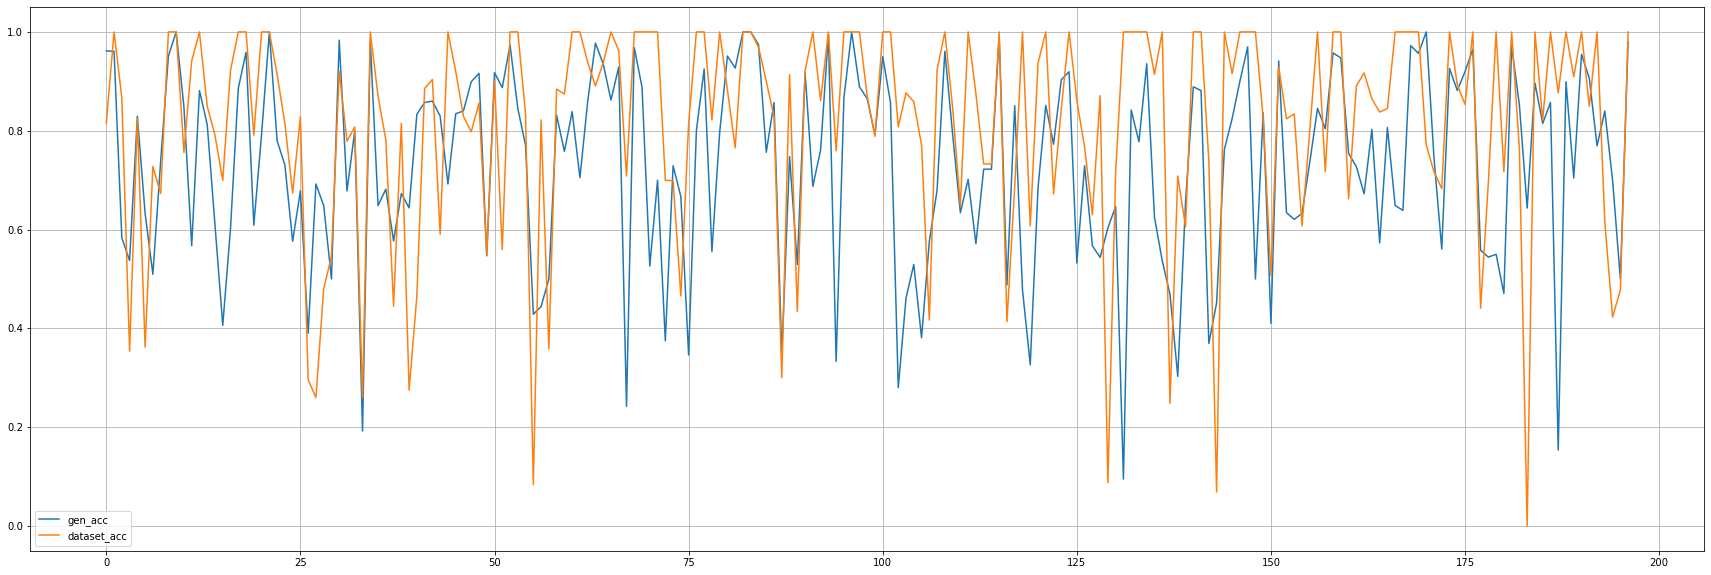

In [39]:
acc_vs_model_aug(class_acc, dataset_class_acc[0])

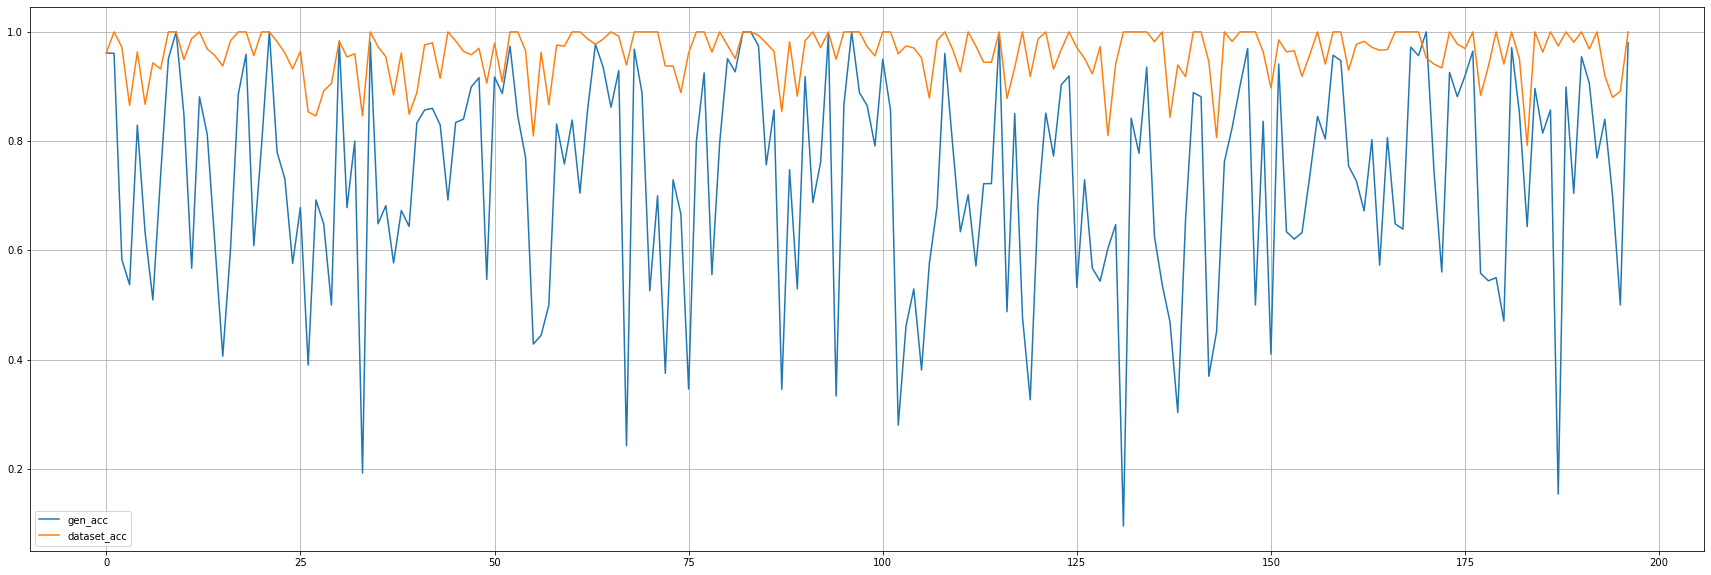

In [40]:
acc_vs_model(class_acc, dataset_class_acc[0])

In [41]:
rank_data = np.vstack((class_rank.astype(np.int64), class_acc[class_rank]))
rank_df = pd.DataFrame(rank_data, index=['class', 'acc'])
pd.set_option('display.max_columns', None)
rank_df

0           1          2          3       4          5    \
class  131.000000  187.000000  33.000000  67.000000  102.00  138.00000   
acc      0.095238    0.153846   0.192308   0.242424    0.28    0.30303   

              6          7          8          9           10      11   \
class  119.000000  94.000000  87.000000  75.000000  142.000000  72.000   
acc      0.326531   0.333333   0.345455   0.346154    0.369565   0.375   

              12         13        14          15         16         17   \
class  105.000000  26.000000  15.00000  150.000000  55.000000  56.000000   
acc      0.380952   0.390244   0.40625    0.410256   0.428571   0.444444   

              18          19         20          21          22          23   \
class  143.000000  103.000000  137.00000  180.000000  118.000000  116.000000   
acc      0.451613    0.461538    0.46875    0.470588    0.478261    0.487805   

        24     25     26    27        28         29          30         31   \
class  29.0  148.0  195.0  57.0  6.000000  70.000000  104.000000  89.000000   
acc     0.5    0.5    0.5   0.5  0.509434   0.526316    0.529412   0.529412   

              32          33        34          35          36         37   \
class  125.000000  136.000000  3.000000  128.000000  178.000000  49.000000   
acc      0.532374    0.537037  0.537313    0.543624    0.544304   0.546875   

          38         39         40         41          42         43   \
class  179.00  78.000000  177.00000  172.00000  127.000000  11.000000   
acc      0.55   0.555556    0.55814    0.56044    0.567308   0.567347   

              44          45          46         47         48        49   \
class  112.000000  164.000000  106.000000  24.000000  37.000000  2.000000   
acc      0.571429    0.573034    0.575758   0.576271   0.576923  0.583333   

             50          51         52         53         54       55   \
class  16.000000  129.000000  14.000000  19.000000  153.00000  135.000   
acc     0.602151    0.603448   0.608696   0.608696    0.62069    0.625   

              56        57          58          59          60          61   \
class  154.000000  5.000000  152.000000  110.000000  167.000000  183.000000   
acc      0.632653  0.632653    0.634146    0.634146    0.638889    0.643564   

             62          63         64          65         66          67   \
class  39.000000  130.000000  28.000000  166.000000  35.000000  139.000000   
acc     0.643836    0.647059   0.648649    0.648649   0.648649    0.655738   

             68          69         70         71         72      73   \
class  74.000000  162.000000  38.000000  31.000000  25.000000  107.00   
acc     0.666667    0.672414   0.673077   0.678161   0.678571    0.68   

             74          75       76         77         78     79    80   \
class  36.000000  120.000000  91.0000  27.000000  44.000000  194.0  71.0   
acc     0.681818    0.684211   0.6875   0.692308   0.692308    0.7   0.7   

              81          82         83          84          85          86   \
class  111.000000  189.000000  61.000000  114.000000  113.000000  161.000000   
acc      0.701613    0.704403   0.704918    0.722222    0.722222    0.727273   

             87          88         89          90        91          92   \
class  73.000000  126.000000  23.000000  155.000000  7.000000  171.000000   
acc     0.729167    0.729167   0.730769    0.736111  0.737864    0.745098   

             93          94         95        96         97          98   \
class  88.000000  160.000000  85.000000  59.00000  92.000000  144.000000   
acc     0.747748    0.754386   0.756477   0.75817   0.761317    0.761905   

              99         100         101         102        103        104  \
class  192.000000  54.000000  122.000000  133.000000  22.000000  99.000000   
acc      0.769231   0.770115    0.772727    0.777778   0.779762   0.791209   

             105         106        107   108   109         110         111  \
class  20.00

/home/thorreign/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[  0  21  48 129 171]


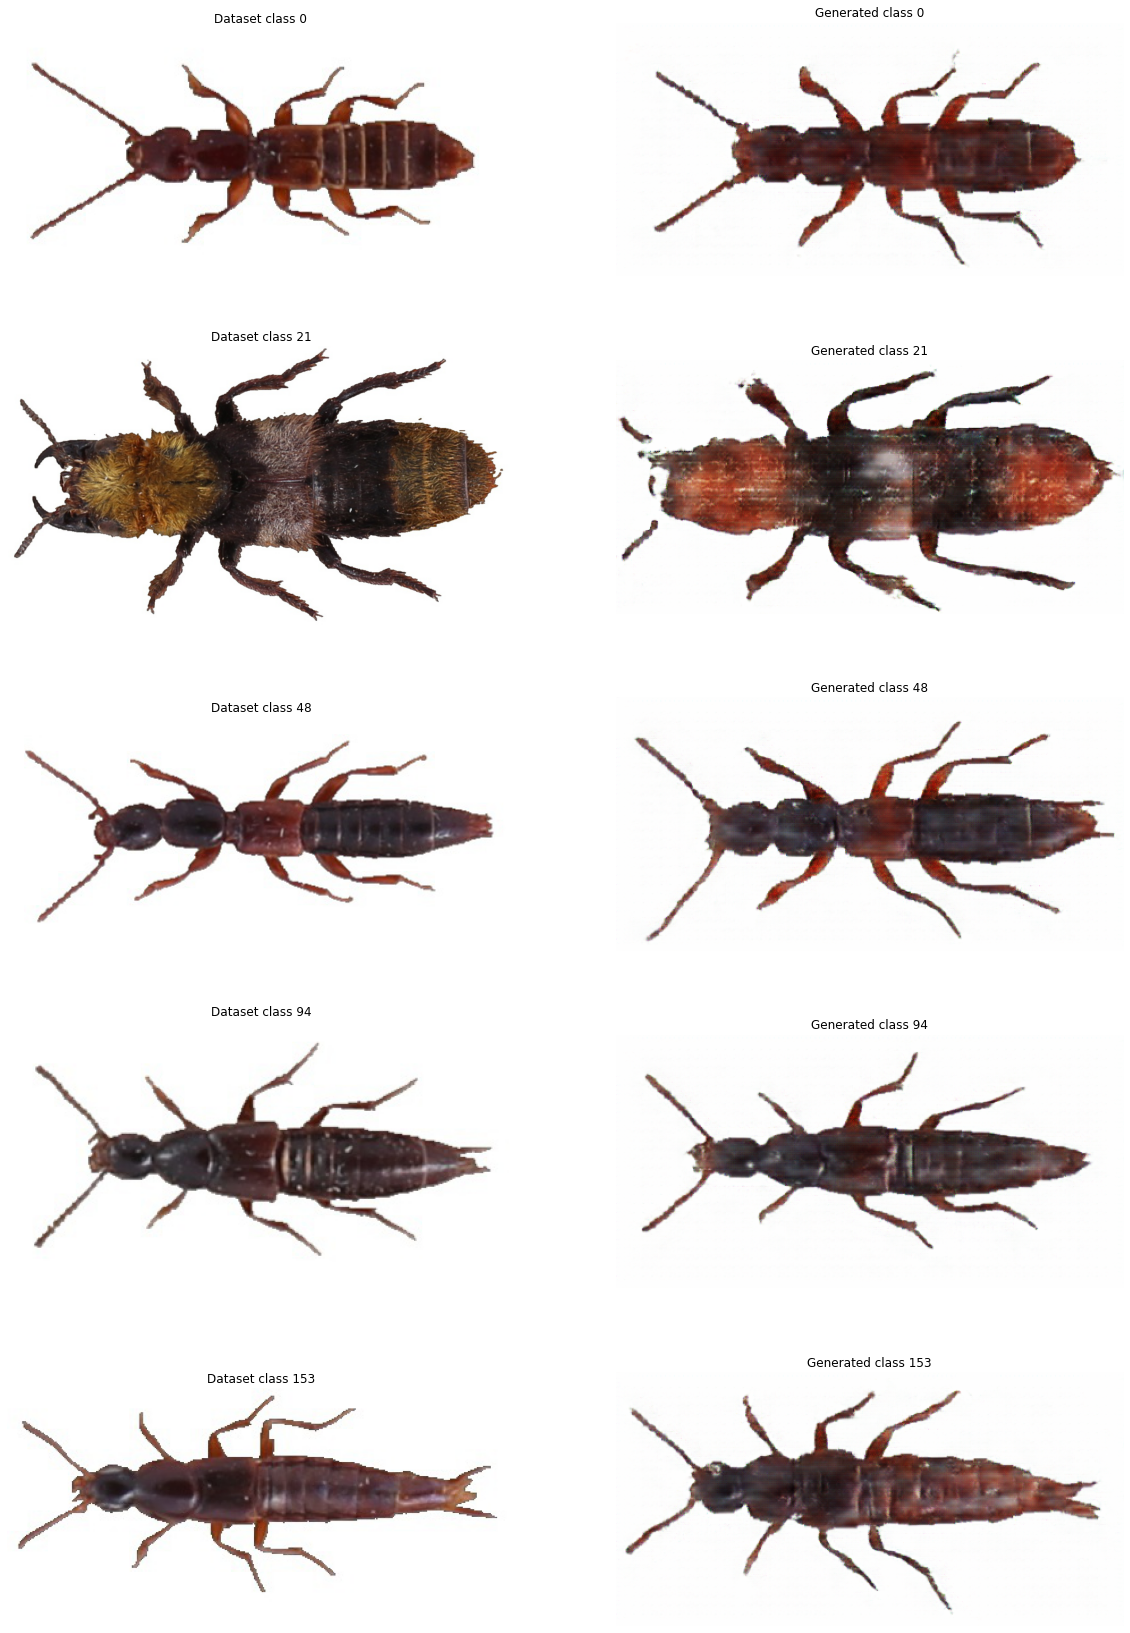

In [42]:
visual_insection(net_G, net_E, model, 'logits_200')

In [43]:
class_name = os.listdir('./data/beetles/images')

class_name.sort()
class_name[50]


'lathrobium_impressum'

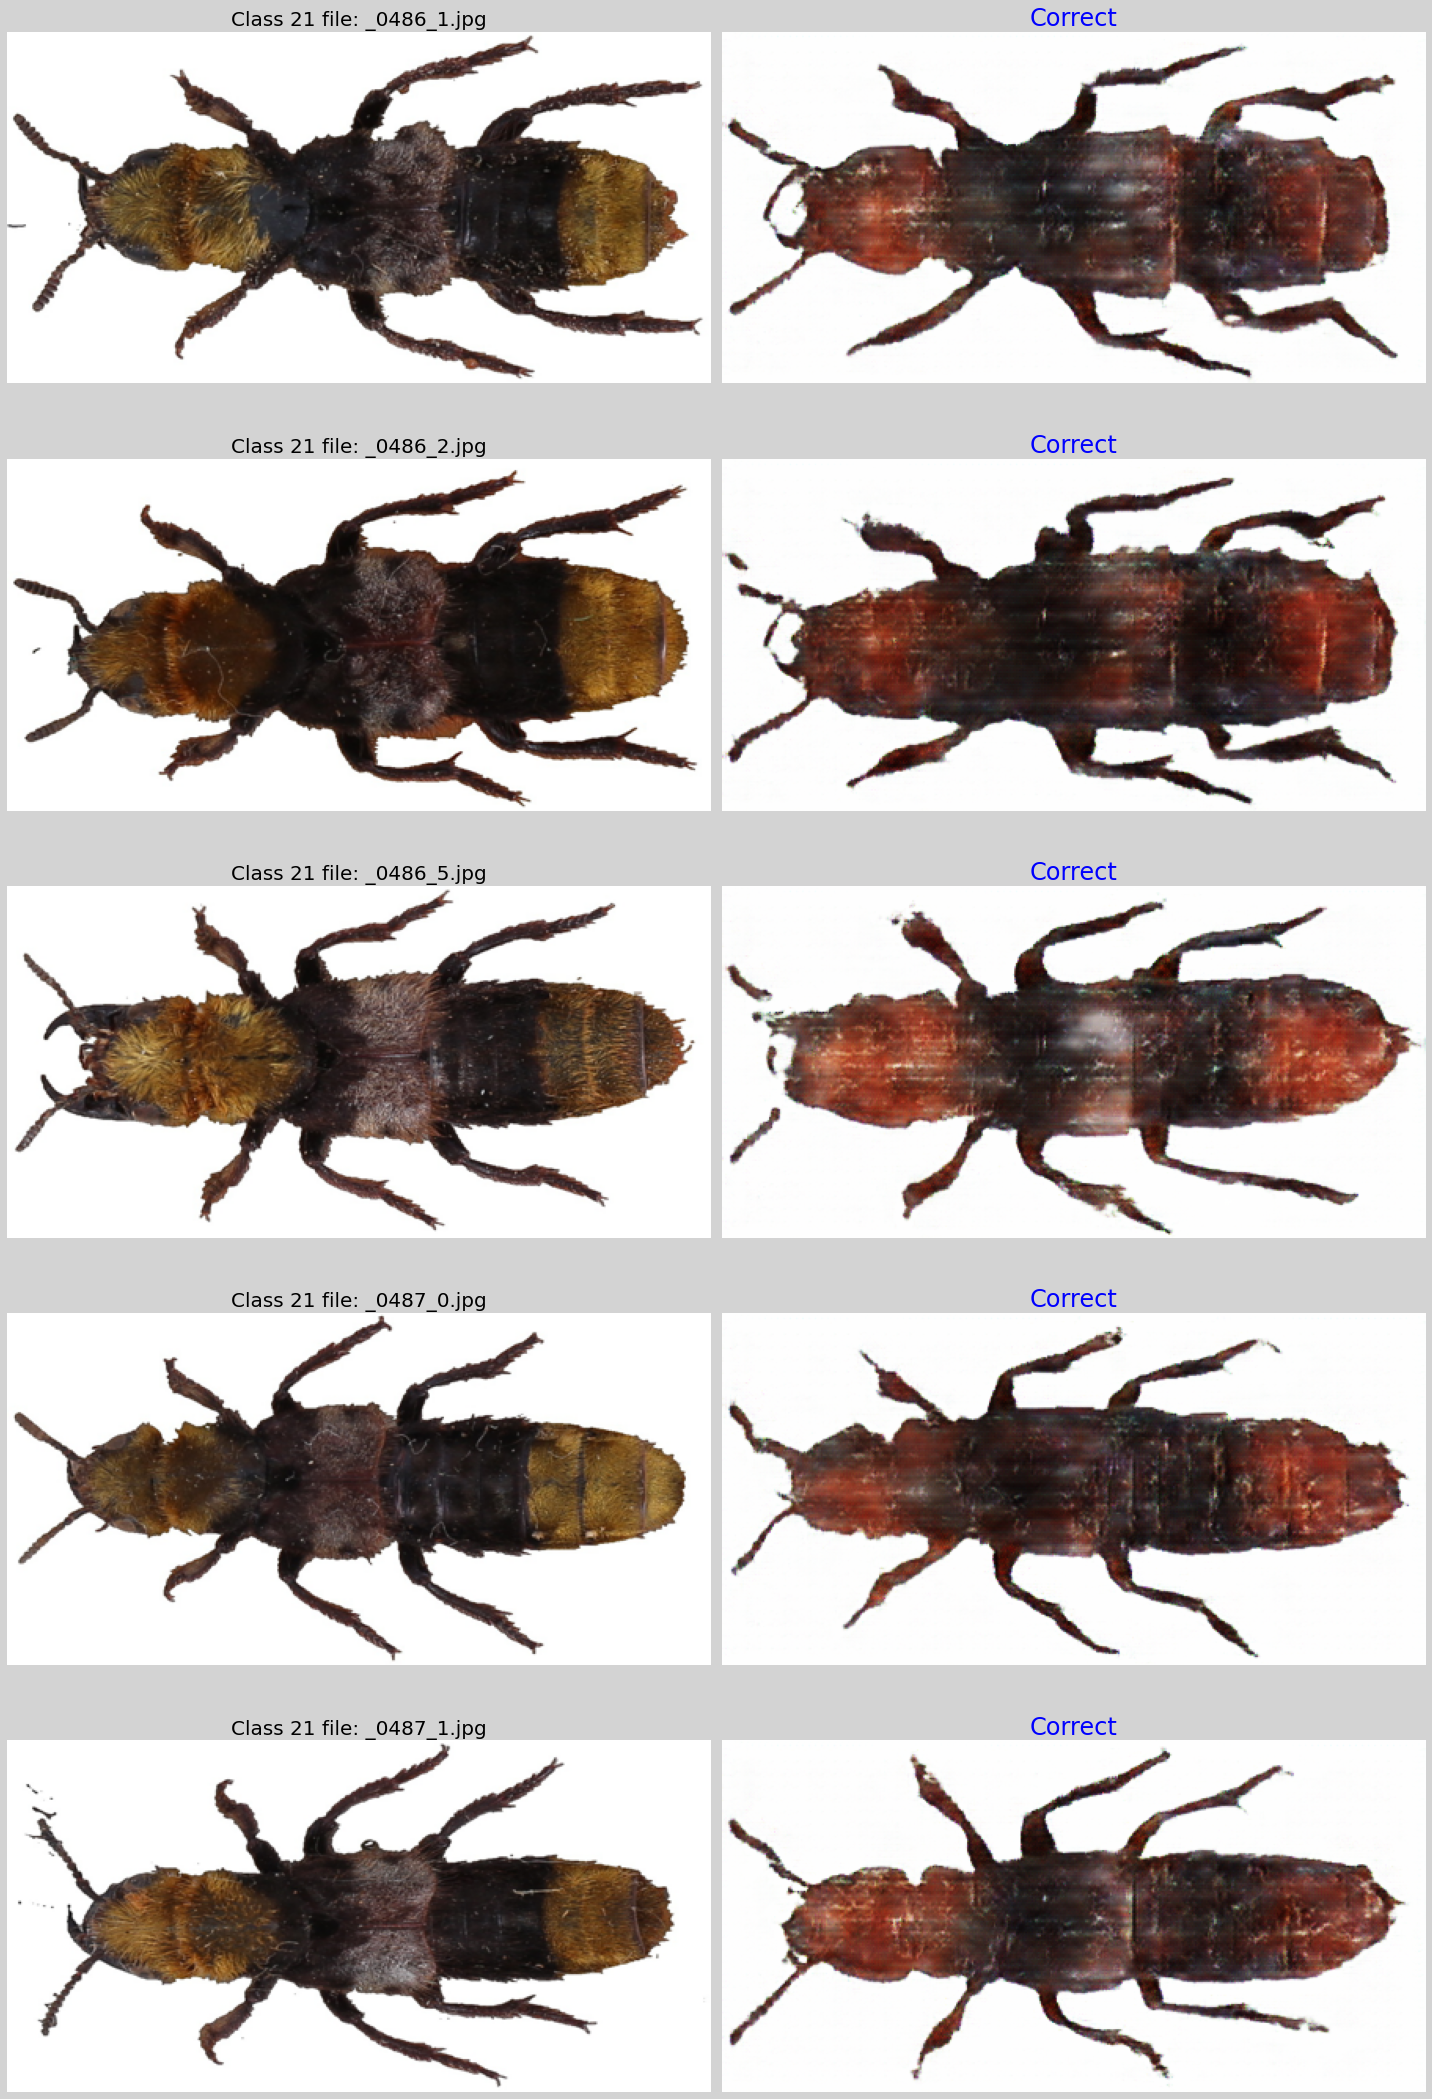

In [44]:
show_class(data_by_class, 21, 0, net_G)